<strong>Prendre le fichier geoJSON et en faire un dataframe avec une colonne latitude et une colonne longitude et chaque ligne est un point

In [38]:
import geopandas as gpd

gdf = gpd.read_file("../data/reanimation.geojson")
gdf['latitude'] = gdf['geometry'].y
gdf['longitude'] = gdf['geometry'].x

df = gdf[["latitude","longitude"]]

df.to_csv("points.csv",index=False)

<strong>Test algorithme des K-means</strong>

In [39]:
from sklearn.cluster import KMeans
import numpy as np

# Générer des données aléatoires
X = np.array(df[["latitude", "longitude"]])
# print(X)

# Initialiser l'algorithme des K-means avec 3 clusters
kmeans = KMeans(n_clusters=6)

# Exécuter l'algorithme des K-means sur les données
kmeans.fit(X)

# Prédire le cluster associé à chaque point
labels = kmeans.predict(X)

# Afficher les labels prédits pour chaque point
print(labels)   #numéro du cluster pour chaque donnée
df["Id_cluster"] = labels
df.to_csv("points.csv", index=False)

# print(kmeans.cluster_centers_)  #position centre cluster


[[ 5.06344931e+01  3.03119020e+00]
 [ 4.88925356e+01  2.27242080e+00]
 [ 5.06057446e+01  3.03290150e+00]
 [ 5.06075100e+01  3.03289130e+00]
 [ 4.49137014e+01  4.90540020e+00]
 [ 4.87959793e+01  2.45284250e+00]
 [ 5.04161175e+01  1.56409900e+00]
 [ 4.58136934e+01  1.23977820e+00]
 [ 4.92452980e+00 -5.23208688e+01]
 [ 4.33100687e+01  5.37230150e+00]
 [ 4.94397836e+01  1.10614410e+00]
 [ 4.35566623e+01  1.42647660e+00]
 [ 4.59322381e+01  6.11720590e+00]
 [ 4.57496618e+01  4.83589070e+00]
 [ 4.89249789e+01  2.23621850e+00]
 [ 4.88708091e+01  2.22240520e+00]
 [ 4.52008162e+01  5.74461820e+00]
 [ 4.84018937e+01 -4.52828320e+00]
 [ 5.06084479e+01  3.03432260e+00]
 [ 4.96372750e+01 -1.61309770e+00]
 [ 4.63173673e+01 -4.61703800e-01]
 [ 4.87567961e+01  2.30367240e+00]
 [ 4.94284956e+01  1.09674050e+00]
 [ 4.31810180e+01  3.00014800e+00]
 [ 4.88663636e+01  2.40200510e+00]
 [ 4.88284833e+01  2.33908370e+00]
 [ 4.88782539e+01  2.37763370e+00]
 [ 4.88370175e+01  2.33992810e+00]
 [ 4.88294209e+01  2

c:\Users\paulp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\paulp\AppData\Local\Temp\ipykernel_8676\476403480.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Id_cluster"] = labels


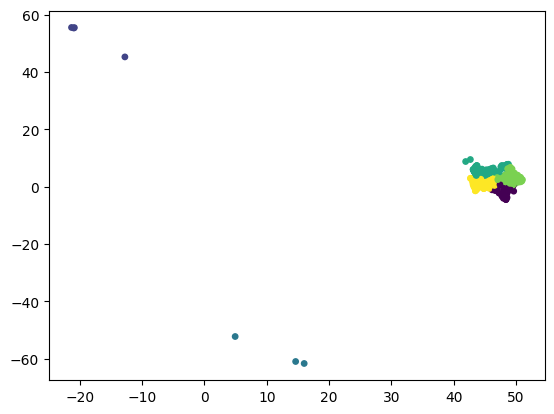

In [40]:
import matplotlib.pyplot as plt


# Affichage des clusters
plt.scatter(X[:,0], X[:,1], s = 15, c = kmeans.labels_)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 10, c = 'g', marker='s')
plt.show()

Test algorithme EM (gaussianmixture)

[[48.97640523  2.34001572]
 [48.8978738   2.52408932]
 [48.9867558   2.20227221]
 [48.89500884  2.28486428]
 [48.78967811  2.34105985]
 [48.81440436  2.44542735]
 [48.87610377  2.3121675 ]
 [48.84438632  2.33336743]
 [48.94940791  2.27948417]
 [48.83130677  2.21459043]
 [48.54470102  2.36536186]
 [48.88644362  2.2257835 ]
 [49.02697546  2.15456343]
 [48.80457585  2.28128161]
 [48.95327792  2.44693588]
 [48.81549474  2.33781625]
 [48.71122143  2.10192035]
 [48.76520879  2.3156349 ]
 [48.92302907  2.42023798]
 [48.76126732  2.26976972]
 [48.6951447   2.15799821]
 [48.62937298  2.49507754]
 [48.74903478  2.25619257]
 [48.67472046  2.37774904]
 [48.63861022  2.27872597]
 [48.71045334  2.33869025]
 [48.74891949  2.18193678]
 [48.79718178  2.34283319]
 [48.80665172  2.33024719]
 [48.73656779  2.26372588]
 [48.73275396  2.26404468]
 [48.71868537  2.12737174]
 [48.81774261  2.25982191]
 [48.63698017  2.34627823]
 [48.70927016  2.30519454]
 [48.87290906  2.31289829]
 [48.91394007  2.17651742]
 

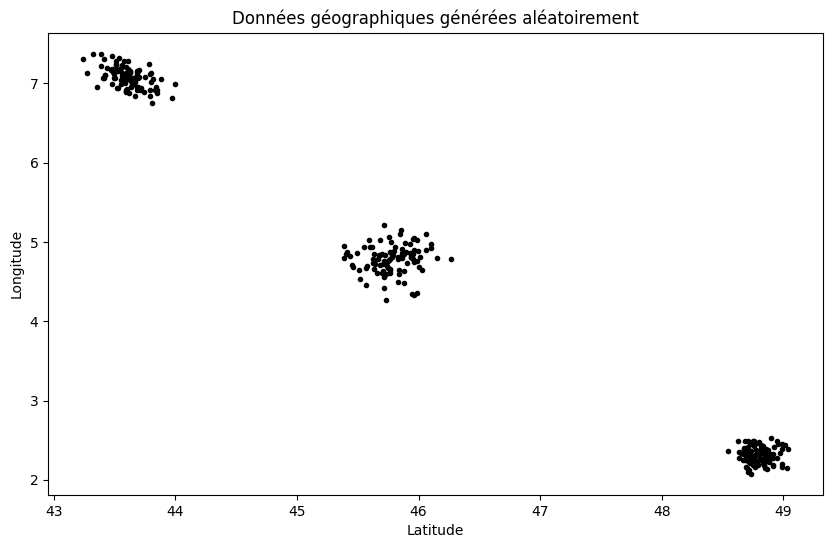

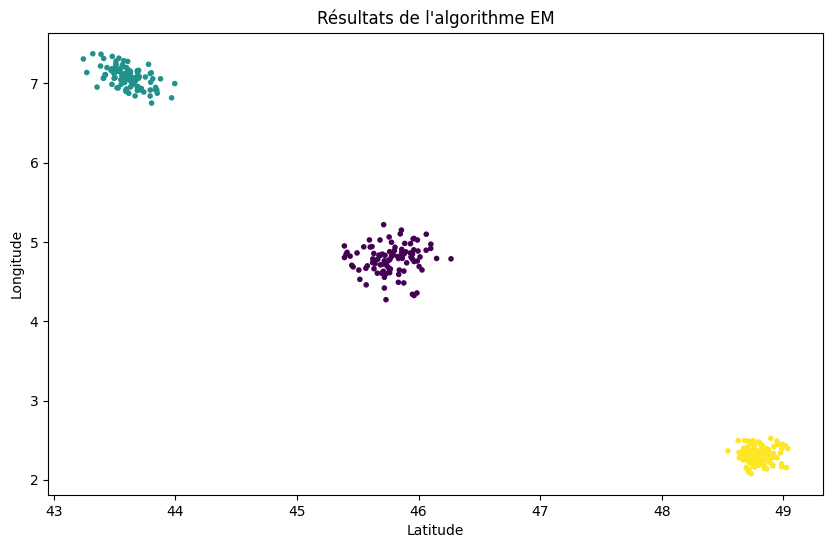

In [41]:
# Importer les bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Générer des données aléatoires à partir de trois distributions gaussiennes multivariées
np.random.seed(0) # fixer la graine aléatoire pour la reproductibilité
n_samples = 100 # nombre d'échantillons par distribution
mean1 = [48.8, 2.3] # moyenne du premier groupe (correspondant à Paris)
cov1 = [[0.01, 0], [0, 0.01]] # covariance du premier groupe
mean2 = [43.6, 7.1] # moyenne du deuxième groupe (correspondant à Nice)
cov2 = [[0.02, -0.01], [-0.01, 0.02]] # covariance du deuxième groupe
mean3 = [45.8, 4.8] # moyenne du troisième groupe (correspondant à Lyon)
cov3 = [[0.03, 0], [0, 0.03]] # covariance du troisième groupe
X1 = np.random.multivariate_normal(mean1, cov1, n_samples) # générer les échantillons du premier groupe
X2 = np.random.multivariate_normal(mean2, cov2, n_samples) # générer les échantillons du deuxième groupe
X3 = np.random.multivariate_normal(mean3, cov3, n_samples) # générer les échantillons du troisième groupe
X = np.concatenate((X1,X2,X3)) # concaténer les échantillons en une seule matrice
print(X)

# Afficher les données générées sur un graphique
plt.figure(figsize=(10,6)) # créer une figure avec une taille donnée
plt.scatter(X[:,0], X[:,1], c='black', marker='.') # tracer les points avec une couleur et un marqueur donnés
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Données géographiques générées aléatoirement') # ajouter un titre au graphique

# Appliquer l'algorithme EM avec le nombre de clusters fixé à 3 
gm = GaussianMixture(n_components=3) # créer un objet GaussianMixture avec le nombre de composantes fixé à 3 
gm.fit(X) # ajuster le modèle aux données 
y_pred = gm.predict(X) # prédire le cluster de chaque point

# Afficher les résultats de l'algorithme EM sur un autre graphique
plt.figure(figsize=(10,6)) # créer une autre figure avec une taille donnée
plt.scatter(X[:,0], X[:,1], c=y_pred, marker='.') # tracer les points avec une couleur correspondant au cluster prédit et un marqueur donné
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Résultats de l\'algorithme EM') # ajouter un titre au graphique

# Afficher les paramètres des distributions estimés par l'algorithme EM 
print('Moyennes des distributions:')
print(gm.means_)
print('Covariances des distributions:')
print(gm.covariances_)
